In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

# Lecture des données

In [2]:
#args : fichier de données à lire
#renvoie : chaque colonne nt, parties réelles, parties imaginaires en liste de liste ([[config 1],...[config N]])
def lecture(fichier): 
    with open(fichier, "r") as f:
        nt = []
        re = []
        im = []
        for line in f:
            data = line.split()
            nt.append(data[0])
            re.append(data[1])
            im.append(data[2])
        nt = nt[1:]
        re = re[1:]
        im = im[1:]
        for i in range(len(nt)):
            nt[i] = float(nt[i])
            re[i] = float(re[i])
            im[i] = float(im[i])
        ntll = [nt[i:i+64] for i in range(0, len(nt),64)]
        rell = [re[i:i+64] for i in range(0, len(re),64)]
        imll = [im[i:i+64] for i in range(0, len(im),64)]
        return ntll, rell, imll

In [3]:
fichier = "./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat"
ntll, rell, imll = lecture(fichier)

In [4]:
#args : listes de listes nt, re, im par configs
#renvoie : liste de liste des normes du corrélateur par nt : [[norme nt=0 config1, norme nt=0 config2,...],[norme nt=N_T config1, norme nt=N_T config2,...]]
def normes_par_nt(ntll, rell, imll):
    nont = []
    for i in range(64):
        nonti = []
        for j in range(len(ntll)):
            nonti.append(np.sqrt((rell[j])[i]**2 + (imll[j])[i]**2))
        nont.append(nonti)
    return nont

In [5]:
#args : listes de listes re, im par configs
#renvoie : liste de liste des parties réelles et imaginaires par nt
def re_im_par_nt(rell, imll):
    rent = []
    imnt = []
    for i in range(64):
        renti = []
        imnti = []
        for j in range(len(rell)):
            renti.append(rell[j][i])
            imnti.append(imll[j][i])
        rent.append(renti)
        imnt.append(imnti)
    return rent, imnt

In [6]:
nont = normes_par_nt(ntll, rell, imll)

In [7]:
rent, imnt = re_im_par_nt(rell, imll)

# Premier fit

In [8]:
#args : liste de liste des normes par nt
#renvoie : liste des moyennes des normes sur les configs par nt, liste des variances des normes sur les configs par nt

def moyenne_norme(nont):
    return [np.mean(nont[i]) for i in range(len(nont))], [np.sqrt(np.var(nont[i])) for i in range(len(nont))]

In [9]:
#args : liste de liste des parties réelles et imaginaires par nt
#renvoie : liste des moyennes des parties réelles et imaginaires sur les configs par nt, liste des variances des parties réelles et imaginaires sur les configs par nt

def moyenne_re_im(rent, imnt):
    return [np.mean(rent[i]) for i in range(len(rent))], [np.sqrt(np.var(rent[i])) for i in range(len(rent))], [np.mean(imnt[i]) for i in range(len(imnt))], [np.sqrt(np.var(imnt[i])) for i in range(len(imnt))]

In [10]:
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)
nomoy = np.sqrt((np.array(remoy))**2+(np.array(immoy))**2)

In [11]:
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

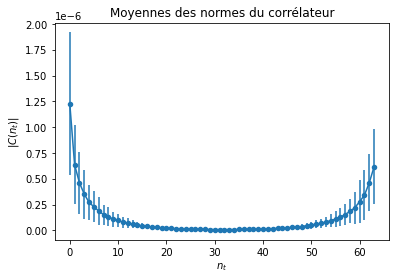

In [12]:
plt.errorbar(xnt,nomoy, sigmaobs,marker='.', mew=2.5);
plt.title("Moyennes des normes du corrélateur");
plt.xlabel(r"$n_t$");
plt.ylabel(r"$|C(n_t)|$");

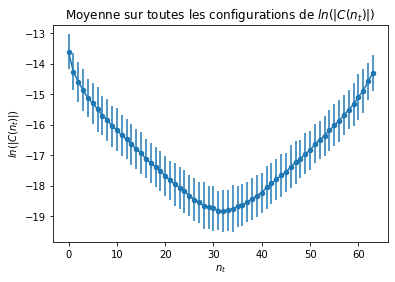

In [13]:
plt.errorbar(xnt,np.log(nomoy), (sigmaobs/np.abs(nomoy)), marker='.', mew=2.5);
plt.title("Moyenne sur toutes les configurations de $ln(|C(n_t)|)$");
plt.xlabel(r"$n_t$");
plt.ylabel(r"$ln(|C(n_t)|)$");

In [14]:
#La fonction que l'on fit à la norme du corrélateur

def fit(nt, A0, E0):
    return A0*np.cosh((nt-32)*E0)

In [15]:
#args : inf, sup : bornes du fit, nomoy : moyennes des normes par nt,  sigmaobs : erreurs statistiques sur les moyennes des normes
#renvoie : [A0, E0, chi2, chi2réduit] : résultats du fit, xdata : [entiers de inf à sup] , ydata : [nomoy de inf à sup], ypred : [fit(A0,E0) de inf à sup]

def estim(inf,sup, nomoy, sigmaobs): 
    xdata = np.array([i for i in range(inf,sup)])
    ydata = np.array(nomoy[inf:sup])
    sigmadata = np.array(sigmaobs[inf:sup])
    popt, pcov = curve_fit(fit, xdata, ydata, sigma = sigmadata, absolute_sigma=True)
    A0 = popt[0]
    E0 = popt[1]
    ddl = sup-inf+1-2
    ypred = fit(xdata, A0, E0)
    chi2 = np.sum(((ydata-ypred)/sigmadata)**2)
    chi2red = chi2/ddl
    return [A0, E0, chi2, chi2red, pcov], xdata, ydata, ypred, sigmadata

# Effective mass plateau

In [16]:
#args : nomoy : moyennes des normes par nt,  sigmaobs : erreurs statistiques sur les moyennes des normes, eps : borne du chi2 du plateau
#renvoie : inf,sup : bornes optimales de l'effective mass plateau déterminées grace au chi2


def plateau(nomoy, sigmaobs, eps):
    chi2 = []
    for i in range(2,31):
        params, xdata, ydata, ypred, sigmadata = estim(31-i, 31+i, nomoy, sigmaobs)
        chi2.append(params[2])
            
    dernier_indice_satisfaisant = -1  # Initialisation avec un indice invalide au cas où aucun élément ne satisfait la condition
    for i, valeur in enumerate(chi2):
        if valeur < eps:
            dernier_indice_satisfaisant = i
    dernier_indice_satisfaisant = dernier_indice_satisfaisant+2
    inf = 31-dernier_indice_satisfaisant
    sup = 31+dernier_indice_satisfaisant
    #print("inf = " + str(inf))
    #print("sup = " + str(sup))
    return inf, sup

In [17]:
eps = 40

In [18]:
inf, sup = plateau(nomoy, sigmaobs,eps)

In [19]:
print(inf, sup)

13 49


On choisit donc comme plateau (13,49) :

In [20]:
params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
print(params[2])

0.022371239783129226


Text(0, 0.5, '$|C(n_t)|$')

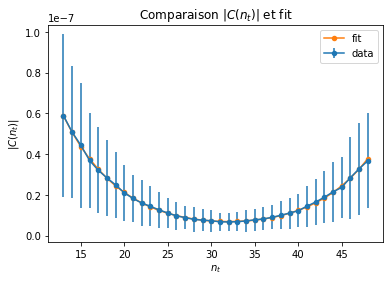

In [21]:
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $|C(n_t)|$ et fit")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$|C(n_t)|$")

In [22]:
a =  0.0652
x = (1/a)*197.327
E0 = params[1]
Mphysmev = E0*x
print("Masse physique : " + str(Mphysmev) + " MeV")

Masse physique : 451.8517202568747 MeV


# Détermination des erreurs

## Jacknife

In [23]:
nconf = 999 #nombre de configurations
a =  0.0652 #taille de la maille du réseau en fm
x = (1/a)*197.327 #conversion fm en MeV
eps = 40

In [24]:
#args : n : la configuration qu'on veut retirer , nt, re, im : ce que renvoie lecture(fichier)
#renvoie : nt, re, im sans la nième config

def jack(n, nt, re, im): 
    nt.pop(n)
    re.pop(n)
    im.pop(n)
    return nt, re, im

In [25]:
def jacknife(nconf, fichier, a, x, eps):
    
    #on calcule d'abord avec toutes les configs
    
    nt, re, im = lecture(fichier)
    nont = normes_par_nt(nt, re, im)
    nomoy, sigmaobs = moyenne_norme(nont)
    inf,sup = plateau(nomoy, sigmaobs, eps)
    params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
    
    E0 = params[1] #on trouve E0 avec toutes les configs
    
    
    E0jn = [] #liste des E0 pour chaque set du jacknife
    
    for n in range(nconf): #on fait le jacknife
        nt, re, im = lecture(fichier)
        ntll, rell, imll = jack(n,nt,re,im)
        
        nont = normes_par_nt(ntll, rell, imll)
        
        nomoy, sigmaobs = moyenne_norme(nont)
        
        inf,sup = plateau(nomoy, sigmaobs, eps)
        
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        
        E0jn.append(params[1])
        
        if (n%100==0): #compteur
            print(n)
            
    E0tild = np.mean(np.array(E0jn))
    biais = (len(E0jn)-1)*(E0tild-E0)
    E0unb = E0 - biais
    sigmajn2 = np.sqrt(np.var(E0jn))
    sigmajn = np.sqrt(((nconf-1)/nconf)*np.sum((np.array(E0jn) - np.ones(nconf)*E0)**2))  #Erreur sur E0 estimée par le jacknife
    
    print("E0 biased= " + str(E0) + " +/- " + str(sigmajn))
    print("M biased = " + str(E0*x) + " +/- " + str(sigmajn*x) + " MeV")
    return E0jn, E0, E0unb, sigmajn
    

In [26]:
#E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)

# Courbe d'énergie effective

## pion-g5-S pion-g5-S 

On choisit le jackknife comme méthode de d'estimation des incertitudes. On se penche tout d'abord sur les pion-g5-S pion-g5-S :

On a : $p_i = 2πk_i/(aN)$, $k_i = −N/2+1, . . .,N/2$

In [27]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [28]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g5S = []
E0unb_g5S_g5S = []
sigmajn_g5S_g5S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g5S.append(E0)
    E0unb_g5S_g5S.append(E0unb)
    sigmajn_g5S_g5S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat


TypeError: jacknife() missing 1 required positional argument: 'eps'

In [29]:
donnees_g5S_g5S = np.array(list(zip(E0_g5S_g5S, E0unb_g5S_g5S, sigmajn_g5S_g5S)))
np.savetxt('__g5S_g5S.dat', donnees_g5S_g5S, fmt='%.20f', delimiter='\t')

ValueError: 'x' and 'y' must have the same size

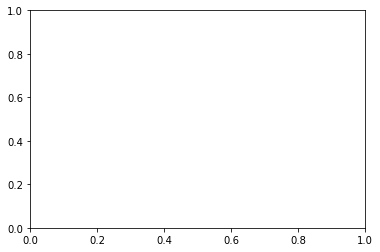

In [30]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S), np.array(sigmajn_g5S_g5S),marker=".", mew=2.5)
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

In [ ]:
pi = [(2*np.pi*i)/(32) for i in range(-8,9)]

In [ ]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S), np.array(sigmajn_g5S_g5S),marker=".", mew=2.5, label="E")
plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

Test $cosh(aE(p)) = cosh(am_H) + (1 − cos(ap_k))$

In [ ]:
left_side = np.cosh(np.array(E0_g5S_g5S))

In [ ]:
N= 32

In [ ]:
cos_ap = np.cos(np.array([(2*np.pi*i)/(N) for i in range(-8, 9)]))

In [ ]:
right_side = np.cosh(np.ones(17)*E0_g5S_g5S[8]) + np.ones(17) - cos_ap

In [31]:
absc = [i for i in range(-8,9)]
plt.plot(absc,left_side, label = r"$cosh(aE(p))$")
plt.plot(absc,right_side, label = r"$cosh(am_H) + (1 − cos(ap_k))$")
plt.title(r"Vérification de $cosh(aE(p)) = cosh(am_H) + (1 − cos(ap_k))$ pour g5S-g5S" + "\n")
plt.xlabel(r"k avec $p_k = 2 \pi k / (aN)$")
plt.legend()

NameError: name 'left_side' is not defined

# Vérification du processus d'extraction de l'effective energy

Vérfication du processus d'extraction de l'effective energy pour un fichier au hasard

In [456]:
fichier = "./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz7.m-0.3303_m-0.3303.n3.dat"

In [457]:
nt, re, im = lecture(fichier)
nont = normes_par_nt(nt, re, im)
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

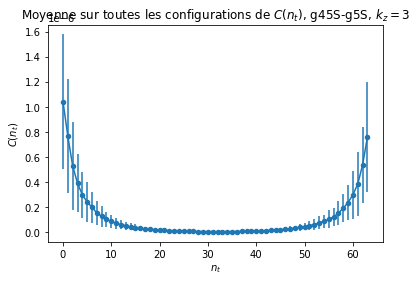

In [458]:
plt.figure()
plt.errorbar(xnt,nomoy, sigmaobs, marker='.', mew=2.5)
plt.title("Moyenne sur toutes les configurations de $C(n_t)$, g45S-g5S, $k_z=3$")
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")
fig = plt.gcf()
fig.savefig('lnc_45s5s.jpg',bbox_inches='tight')

In [459]:
plt.savefig('lnc_5s5s.png')

<Figure size 432x288 with 0 Axes>

In [460]:
#la fonction à fit pour les opérateur croisés g45/g5 ou g5/g45 pour n_t<N_T/2
def fitinf(nt,A0,E0):
    return A0*np.sinh((32-nt)*E0)

In [461]:
#la fonction à fit pour les opérateur croisés g45/g5 ou g5/g45 pour n_t>N_T/2
def fitsup(nt,A0,E0):
    return A0*np.sinh((nt-32)*E0)

In [462]:
#cf la fonction estim précédente mais pour fitinf et fitsup
def estimsinh(inf, sup, nomoy, sigmaobs): 
    nomoyinf = nomoy[inf:32]
    nomoysup = nomoy[32:sup]
    sigmaobsinf = sigmaobs[inf:32]
    sigmaobssup = sigmaobs[32:sup]
    xinf = np.array(range(inf,32))
    xsup = np.array(range(32,sup))

    poptinf, pcovinf = curve_fit(fitinf, xinf, nomoyinf, sigma = sigmaobsinf, absolute_sigma=True)
    A0inf = poptinf[0]
    E0inf = poptinf[1]
    ddlinf = len(xinf)-2
    ypredinf = fitinf(xinf, A0inf, E0inf)
    chi2inf = np.sum(((nomoyinf-ypredinf)/sigmaobsinf)**2)
    chi2redinf = chi2inf/ddlinf
    
    poptsup, pcovsup = curve_fit(fitsup, xsup, nomoysup, sigma = sigmaobssup, absolute_sigma=True)
    A0sup = poptsup[0]
    E0sup = poptsup[1]
    ddlsup = len(xsup)-2
    ypredsup = fitsup(xsup, A0sup, E0sup)
    chi2sup = np.sum(((nomoysup-ypredsup)/sigmaobssup)**2)
    chi2redsup = chi2sup/ddlsup
    
    xdata = range(inf,sup)
    ydata = nomoy[inf:sup]
    ypred = list(ypredinf)+list(ypredsup)
    sigmadata = sigmaobs
    
    return [A0inf, E0inf, chi2inf, chi2redinf, pcovinf],[A0sup, E0sup, chi2sup, chi2redsup, pcovsup], xdata, ydata, ypred, sigmadata

In [463]:
#cf la fonction plateau précédente mais pour fitinf et fitsup
def plateausinh(nomoy, sigmaobs, eps):
    chi2inf = []
    chi2sup = []
    indices = range(18,31)
    for i in indices:
        paraminf, paramsup, xdata, ydata, ypred, sigmadata = estimsinh(31-i, 31+i, nomoy, sigmaobs)
        chi2inf.append(paraminf[2])
        chi2sup.append(paramsup[2])
            
    dernier_indice_satisfaisant_inf = -1
    dernier_indice_satisfaisant_sup = -1  # Initialisation avec un indice invalide au cas où aucun élément ne satisfait la condition
    for i in range(len(chi2inf)):
        if chi2inf[i] < eps:
            dernier_indice_satisfaisant_inf = indices[i]
    for i in range(len(chi2sup)):
        if chi2sup[i] < eps:
            dernier_indice_satisfaisant_sup = indices[i]
    der = min(dernier_indice_satisfaisant_sup,dernier_indice_satisfaisant_inf)
    inf = 31-der
    sup = 31+der
    print("inf = " + str(inf))
    print("sup = " + str(sup))
    return inf, sup

In [464]:
eps = 45
infs, sups = plateausinh(nomoy, sigmaobs, eps)

inf = 12
sup = 50


In [465]:
parinf, parsup, xdatas, ydatas, ypreds, sigmadatas = estimsinh(11,sups,nomoy, sigmaobs)

In [466]:
print(parinf)

[6.677833029137753e-15, 0.9999999918538278, 12314.189155787391, 648.1152187256522, array([[ 5.62871150e-30, -4.07724968e-24],
       [-4.07724968e-24,  2.95524341e-18]])]


In [467]:
params, xdata, ydata, ypred, sigmadata = estim(infs, sups, nomoy, sigmaobs)
print("E_0 cosh = " + str(params[1]))

E_0 cosh = 1.0000000087551175


Text(0, 0.5, '$C(n_t)$')

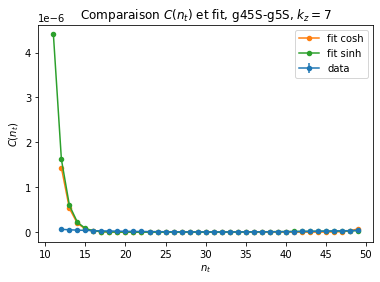

In [468]:
plt.figure()
plt.errorbar(xdata, ydata, sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, ypred, marker=".", mew=2.5, label="fit cosh")
plt.plot(xdatas, ypreds, marker=".", mew=2.5, label="fit sinh")
plt.title(r"Comparaison $C(n_t)$ et fit, g45S-g5S, $k_z=7$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$C(n_t)$")

C:\Users\yacob\AppData\Local\Temp\ipykernel_21440\2293723710.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(xdatas, np.log(ypreds), marker=".", mew=2.5, label="fit sinh")


Text(0, 0.5, '$ln(C(n_t))$')

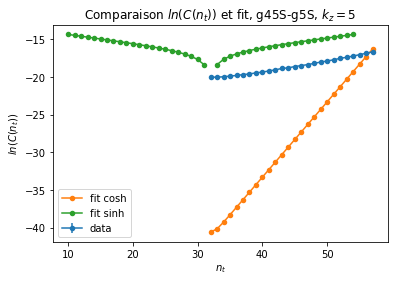

In [348]:
plt.errorbar(xdata, np.log(ydata), sigmadata,marker=".", mew=2.5, label="data")
plt.plot(xdata, np.log(ypred), marker=".", mew=2.5, label="fit cosh")
plt.plot(xdatas, np.log(ypreds), marker=".", mew=2.5, label="fit sinh")
plt.title(r"Comparaison $ln(C(n_t))$ et fit, g45S-g5S, $k_z=5$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$ln(C(n_t))$")

In [305]:
#args = meff, nt, NTT : max(nt), c
#renvoie la fonction telle que ln(C(n_t))/ln(C(n_t+1)) = func_meff(meff)

def func_meff(meff, nt, NTT, c):
    return np.sinh(meff*(nt-NTT/2))/np.sinh(meff*(nt+1-NTT/2)) - c

In [306]:
#args = y : C(n_t) pour n_t allant de inf à sup, inf, sup
#renvoie = les meff correspondant

def solve_meff(y, inf, sup):
    meff = []
    ycorr = []
    for i in range(len(y)-1):
        ycorr.append(y[i]/y[i+1])
    for i in range(len(ycorr)):
        meff.append((fsolve(func_meff, 0.15, args=(i+inf, 64, ycorr[i])))[0])
    return meff

In [194]:
meffdata = solve_meff(nomoy, 0, len(nomoy))
mefffit = solve_meff(ypred, inf, sup)

C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\yacob\AppData\Local\Temp\ipykernel_21440\1767445645.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sinh(meff*(nt-NTT/2))/np.sinh(meff*(nt+1-NTT/2)) - c


In [195]:
def jacknifemeff(nconf, fichier,eps):
    
    #d'abord sans jackknife
    
    nt, re, im = lecture(fichier)
    nont = normes_par_nt(nt, re, im)
    nomoy, sigmaobs = moyenne_norme(nont)
    inf,sup = plateau(nomoy, sigmaobs,eps)
    params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
    
    E0 = params[1] #on trouve E0 sans jacknife d'abord
    meffdata = solve_meff(nomoy, 0, len(nomoy)) #on trouve les meff sans jackknife d'abord
    
    meffjn = [] #liste de liste de meff pour chaque set du jacknife
    E0jn = [] #liste des E0 pour chaque set du jacknife
    
    for n in range(nconf): #on fait le jacknife
        
        nt, re, im = lecture(fichier)
        ntll, rell, imll = jack(n,nt,re,im)
        nont = normes_par_nt(ntll, rell, imll)
        nomoy, sigmaobs = moyenne_norme(nont)
        inf,sup = plateau(nomoy, sigmaobs,eps)
        params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
        E0jn.append(params[1])
        meffdata = solve_meff(nomoy, 0, len(nomoy))
        meffjn.append(meffdata)
        
        if (n%100==0): #compteur
            print(n)
            
    sigmameffjn = []
    for i in range(len(nomoy)-1):
            meffjni = [meffjn[j][i] for j in range(len(meffjn))]
            sigmameffjn.append(np.sqrt(((nconf-1)/nconf)*np.sum((np.array(meffjni) - np.ones(nconf)*meffdata[i])**2)))  #Erreur sur meff[i] estimée par le jacknife
    sigmae0jn = np.sqrt(((nconf-1)/nconf)*np.sum((np.array(E0jn) - np.ones(nconf)*E0)**2))  #Erreur sur E0 estimée par le jacknife
    return meffdata, meffjn, sigmameffjn, sigmae0jn
    

In [196]:
eps = 1

In [185]:
meffdata2, meffjn, sigmameffjn, sigmae0jn = jacknifemeff(999, fichier,eps)

0
100
200
300
400
500
600
700
800
900


Text(0, 0.5, '$m_{eff}$')

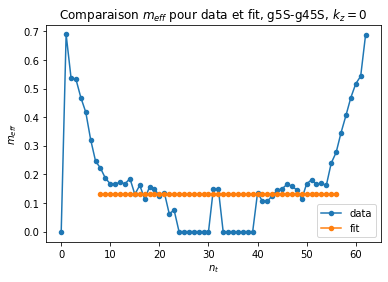

In [202]:
plt.plot(range(len(nomoy)-1), meffdata, marker=".", mew=2.5, label="data")
#plt.errorbar(range(inf, (sup-1)), mefffit, sigmae0jn*np.ones(len(mefffit)),marker=".", mew=2.5, label="fit")
#plt.plot(range(inf, sup), [params[1] for i in range(inf, sup)], marker=".", mew=2.5, label="fit")
plt.plot(range(infs, sups), parsup[1]*np.ones(sups-infs), marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $m_{eff}$ pour data et fit, g5S-g45S, $k_z=0$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$m_{eff}$")

In [203]:
print(mefffit)

[0.15868254783014454, 0.15826348408772528, 0.15767561476704697, 0.1568462895772654, 0.1556677134208649, 0.15397654141961895, 0.15151833961312053, 0.14788190970074608, 0.14236783470584097, 0.13369338495430785, 0.11919741617224401, 0.09178928476890684, 0.00010437798825789962, 2.4568741025197244e-05, 0.00019556494074630764, -0.0001337069940880492, 0.00022161962917223465, 0.0006367151873669153, 0.15, 0.15, -0.0006361356758551868, 0.0004198999640626218, 0.003978885818134619, -8.121912187793347e-05, 1.5400891710916473e-05, 8.210798849668131e-05, 5.288874838826896e-05, 3.249753873055659e-05, -0.00018540266609354044, 0.07164442287967179, 0.10263256257036375, 0.12051565121964893, 0.1321736676827178, 0.14013914368058586, 0.1457099342754828, 0.1496567818763401, 0.152474863224227, 0.1544969164332233, 0.1559525530396001, 0.15700282021001574, 0.15776184464761756, 0.15831105161364437, 0.15870880347173624, 0.1589970683992491, 0.1592060972279437, 0.15935773357212726, 0.15946777166322865, 0.159547643595

In [105]:
plt.errorbar(range(len(nomoy)-1), meffdata, sigmameffjn, marker=".", mew=2.5, label="data")
plt.errorbar(range(inf, (sup-1)), mefffit, sigmae0jn*np.ones(len(mefffit)),marker=".", mew=2.5, label="fit")
plt.title(r"Comparaison $m_{eff}$ pour data et fit, g5S-g5S, $k_z=0$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$m_{eff}$")

NameError: name 'sigmameffjn' is not defined

In [106]:
i = 30
meffni = [meffjn[j][i] for j in range (len(meffdata2))]

NameError: name 'meffdata2' is not defined

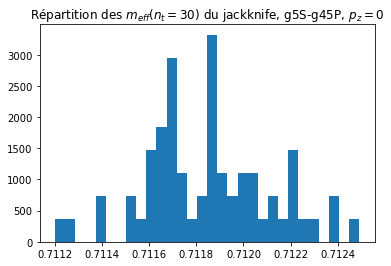

In [112]:
plt.hist(meffni, bins = 30, density = True);
plt.title(r"Répartition des $m_{eff}(n_t = $" + str(i) + r") du jackknife, g5S-g45P, $p_z=0$")
plt.savefig("problem_jn.jpg")

In [123]:
def gaussian(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))

In [127]:
def bimodal_normal_pdf(x, mu1, sigma1, mu2, sigma2, weight1, weight2):
    pdf1 = weight1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (sigma1 * np.sqrt(2 * np.pi))
    pdf2 = weight2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (sigma2 * np.sqrt(2 * np.pi))
    return pdf1 + pdf2

In [145]:
hist, bin_edges = np.histogram(meffni, bins = 30, density=True)
xfitg = bin_edges[:30]
poptg, pcovg = curve_fit(bimodal_normal_pdf, xfitg, hist, bounds = ([0.71,0,0.71,0,0.4,0.4],[0.72,0.01,0.72,0.01,0.6,0.6]))
print(poptg)
ypredg = gaussian(np.array(xfitg), poptg[0], poptg[1])

[7.11643547e-01 6.77562184e-05 7.11953556e-01 1.65875137e-04
 4.00000000e-01 5.21654139e-01]


Text(0.5, 1.0, 'Répartition des $m_{eff}(n_t = $30) du jackknife, g5S-g45P, $p_z=0$')

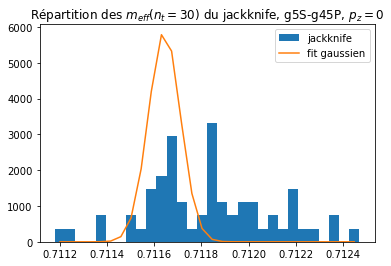

In [146]:
plt.hist(meffni, bins = 30, align="left", density = True, label = "jackknife");
plt.plot(xfitg, ypredg, label = "fit gaussien")
plt.legend()
plt.title(r"Répartition des $m_{eff}(n_t = $" + str(i) + r") du jackknife, g5S-g45P, $p_z=0$")

La détermination du plateau et le fit fonctionnent correctement

# Détermination de juste m_eff sans fit

Ici on détermine juste meff sans faire de fit en utilisant C(n_t)/C(n_t+1) = cosh(meff(nt-NT/2))/cosh(meff(nt+1-NT/2)) et idem avec sinh

In [479]:
fichier = "./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz8.m-0.3303_m-0.3303.n3.dat"

In [480]:
nt, re, im = lecture(fichier)
nont = normes_par_nt(nt, re, im)
remoy, sigmare, immoy, sigmaim = moyenne_re_im(rent, imnt)
nomoy, sigmaobs = moyenne_norme(nont)
xnt = [i for i in range(64)]

In [481]:
def func_meff_sin(meff, nt, NTT, c):
    return np.sinh(meff*(nt-NTT/2))/np.sinh(meff*(nt+1-NTT/2)) - c

In [482]:
def func_meff_cos(meff, nt, NTT, c):
    return np.cosh(meff*(nt-NTT/2))/np.cosh(meff*(nt+1-NTT/2)) - c

In [483]:
#args = y : C(n_t) pour n_t allant de inf à sup, inf, sup
#renvoie = les meff correspondant

def solve_meff_sin(y, inf, sup):
    meff = []
    ycorr = []
    for i in range(len(y)-1):
        ycorr.append(y[i]/y[i+1])
    for i in range(len(ycorr)):
        meff.append((fsolve(func_meff_sin, 0.15, args=(i+inf, 64, ycorr[i])))[0])
    return meff

In [484]:
#args = y : C(n_t) pour n_t allant de inf à sup, inf, sup
#renvoie = les meff correspondant

def solve_meff_cos(y, inf, sup):
    meff = []
    ycorr = []
    for i in range(len(y)-1):
        ycorr.append(y[i]/y[i+1])
    for i in range(len(ycorr)):
        meff.append((fsolve(func_meff_cos, 0.15, args=(i+inf, 64, ycorr[i])))[0])
    return meff

In [485]:
meffdatasin = solve_meff_sin(nomoy, 0, len(nomoy))
meffdatacos = solve_meff_cos(nomoy, 0, len(nomoy))

meffdata2 = [np.arcsinh((nomoy[i+1]+nomoy[i-1])/(2*nomoy[i])) for i in range(1,len(nomoy)-1)]

C:\Users\yacob\AppData\Local\Temp\ipykernel_21440\2046726255.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sinh(meff*(nt-NTT/2))/np.sinh(meff*(nt+1-NTT/2)) - c


In [486]:
print(meffdata)

[-5.3517345494199354e-05, 0.6896067503403853, 0.5378864326386198, 0.5328653785802765, 0.4686497265541645, 0.41785511318943075, 0.3213797862439376, 0.24616261848662155, 0.22201303463393687, 0.18658700966692746, 0.1670468489412005, 0.16671506524217694, 0.17239993322086478, 0.1671539991439648, 0.1857437787676535, 0.13033499494835823, 0.16213437393219735, 0.11442558669410768, 0.15631192731324278, 0.1500271254329826, 0.12357054656188289, 0.13667744693137004, 0.06256385839165542, 0.07514104384501868, -1.959789832612625e-05, -1.9645139208909407e-05, 1.2678258435875256e-06, 0.00013624707345597696, -0.000158014758279908, -7.604786488969972e-05, -0.0005731644474935653, 0.15, 0.15, -0.0017635730762162027, 2.0470274535040398e-05, -3.6713871941906385e-05, -0.0007050841185703739, -0.00021470459814887952, 2.139011367312054e-06, -2.492729346604215e-05, 0.13642504199350067, 0.10565233296125481, 0.1061626116618023, 0.12588903730472503, 0.14443834356098798, 0.15005747496830013, 0.16527896545015777, 0.159

Text(0, 0.5, '$m_{eff}$')

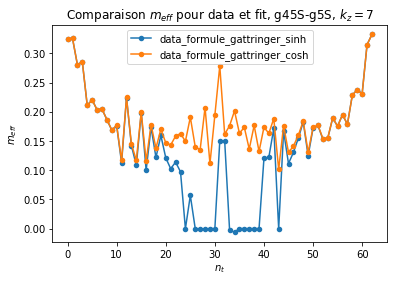

In [487]:
plt.plot(range(len(nomoy)-1), meffdatasin, marker=".", mew=2.5, label="data_formule_gattringer_sinh")
plt.plot(range(len(nomoy)-1), meffdatacos, marker=".", mew=2.5, label="data_formule_gattringer_cosh")
#plt.plot(range(1,len(nomoy)-1), meffdata2, marker=".", mew=2.5, label="data_formule_savvas")
plt.title(r"Comparaison $m_{eff}$ pour data et fit, g45S-g5S, $k_z=7$")
plt.legend()
plt.xlabel(r"$n_t$")
plt.ylabel(r"$m_{eff}$")

# m_eff data/fit en fonction de p pour chaque config

Pas à jour, ne pas compiler

8 54


C:\Users\yacob\AppData\Local\Temp\ipykernel_3388\2180411162.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sinh(meff*(nt-NTT/2))/np.sinh(meff*(nt+1-NTT/2)) - c


9 53
8 54
8 54
8 54
8 54
11 51
7 55
4 58
7 55
11 51
8 54
8 54
8 54
8 54
9 53
8 54


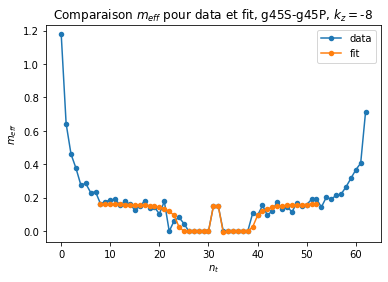

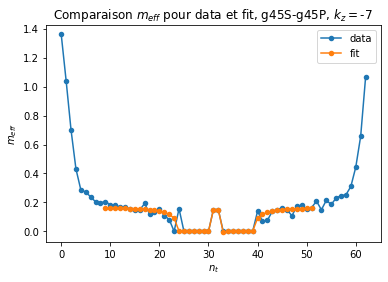

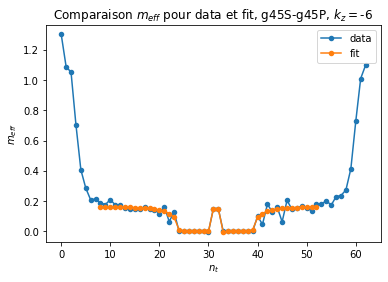

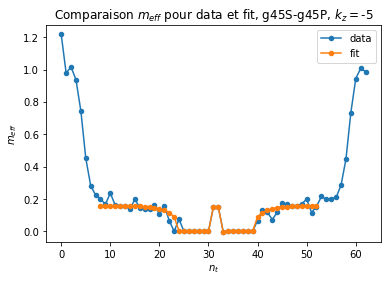

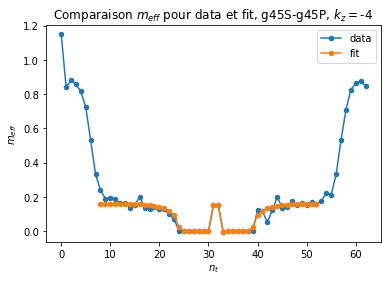

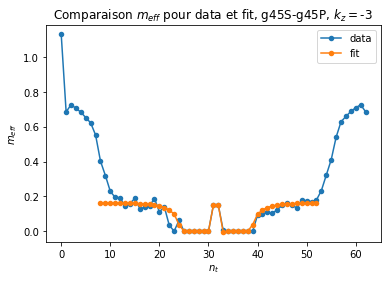

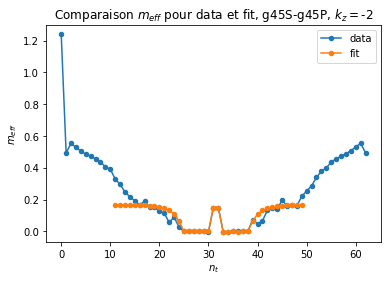

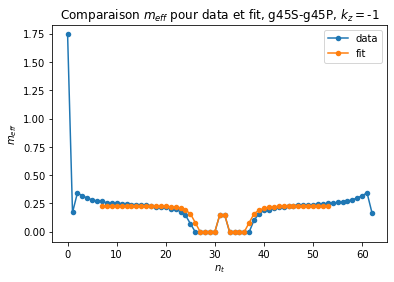

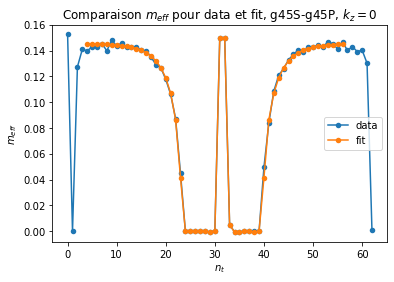

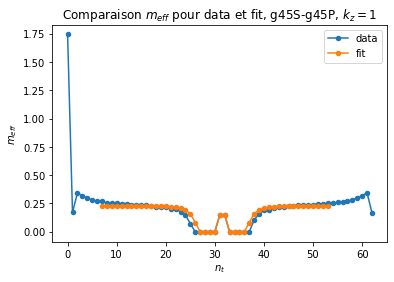

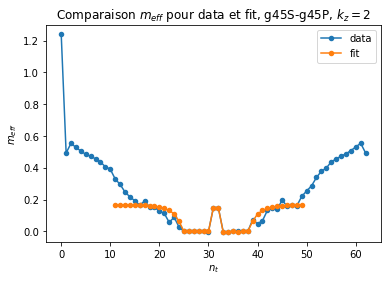

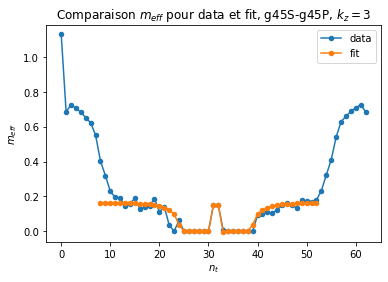

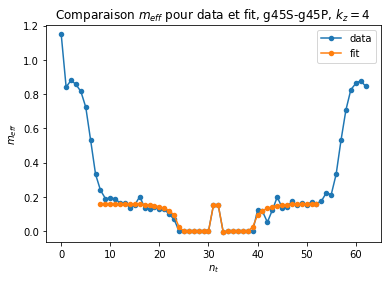

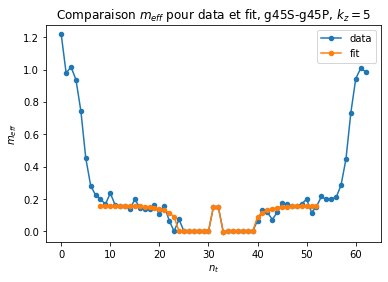

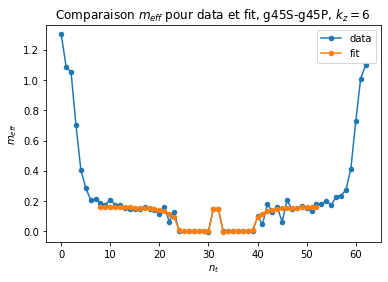

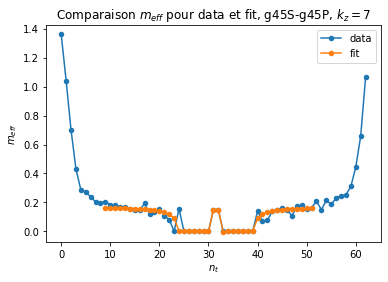

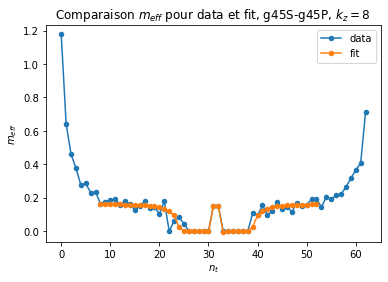

In [245]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
test_meffp = []
for i in range(-8,9):
    fichier = list_fichiers[i+8]
    nt, re, im = lecture(fichier)
    nont = normes_par_nt(nt, re, im)
    nomoy, sigmaobs = moyenne_norme(nont)
    xnt = [i for i in range(64)]
    eps = 2
    inf, sup = plateau(nomoy, sigmaobs,eps)
    print(inf,sup)
    params, xdata, ydata, ypred, sigmadata = estim(inf, sup, nomoy, sigmaobs)
    meffdata = solve_meff(nomoy, 0, len(nomoy))
    mefffit = solve_meff(ypred, inf, sup)
    test_meffp.append(mefffit[0])
    #meffdata2, meffjn, sigmameffjn, sigmae0jn = jacknifemeff(999, fichier,eps)
    plt.figure()
    plt.plot(range(len(nomoy)-1), meffdata, marker=".", mew=2.5, label="data")
    plt.plot(range(inf, (sup-1)), mefffit,marker=".", mew=2.5, label="fit")
    plt.title(r"Comparaison $m_{eff}$ pour data et fit, g45S-g45P, $k_z=$"+str(i))
    plt.legend()
    plt.xlabel(r"$n_t$")
    plt.ylabel(r"$m_{eff}$")
    plt.savefig("g45sg45p_meff_nojn_pz"+str(i)+".jpg")

## pion-g5-S pion-g5-P

In [119]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [120]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g5P = []
E0unb_g5S_g5P = []
sigmajn_g5S_g5P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g5P.append(E0)
    E0unb_g5S_g5P.append(E0unb)
    sigmajn_g5S_g5P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


600
700
800
900
E0 biased= 0.15356576187767854 +/- 0.03728429504602477
M biased = 464.76489408031716 +/- 112.84046148078114 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1554157335975643 +/- 0.04299244911772537
M biased = 470.3638107915119 +/- 130.11611974008275 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1534588156289081 +/- 0.05745424832868967
M biased = 464.4412225706373 +/- 173.88457760667714 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15341528467235016 +/- 0.054048100903147614
M biased = 464.3094766647369 +/- 163.57591421649403 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,

In [121]:
donnees_g5S_g5P = np.array(list(zip(E0_g5S_g5P, E0unb_g5S_g5P, sigmajn_g5S_g5P)))
np.savetxt('__g5S_g5P.dat', donnees_g5S_g5P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

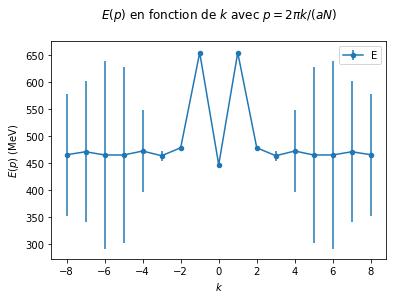

In [122]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="E")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g45-S

In [123]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [124]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g45S = []
E0unb_g45S_g45S = []
sigmajn_g45S_g45S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g45S.append(E0)
    E0unb_g45S_g45S.append(E0unb)
    sigmajn_g45S_g45S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15327631020251867 +/- 0.012594577312538744
M biased = 463.8888721370001 +/- 38.117333701707565 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1538324806967042 +/- 0.01016954145951547
M biased = 465.57211531347474 +/- 30.777992447573766 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15300408509236518 +/- 0.011940831516870962
M biased = 463.064986181306 +/- 36.138780072539824 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15312

In [125]:
donnees_g45S_g45S = np.array(list(zip(E0_g45S_g45S, E0unb_g45S_g45S, sigmajn_g45S_g45S)))
np.savetxt('__g45S_g45S.dat', donnees_g45S_g45S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

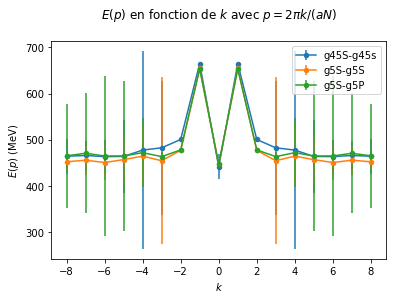

In [126]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45S)*x, np.array(sigmajn_g45S_g45S)*x,marker=".", mew=2.5, label="g45S-g45s")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S)*x, np.array(sigmajn_g5S_g5S)*x,marker=".", mew=2.5, label="g5S-g5S")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="g5S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g45-P

In [127]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [128]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g45P = []
E0unb_g45S_g45P = []
sigmajn_g45S_g45P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g45P.append(E0)
    E0unb_g45S_g45P.append(E0unb)
    sigmajn_g45S_g45P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16158251243770247 +/- 0.033457344195057484
M biased = 489.027491285192 +/- 101.25824168678082 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


400
500
600
700
800
900
E0 biased= 0.16019922278105175 +/- 0.046990829958157544
M biased = 484.8409821122179 +/- 142.21717029376313 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16044410812195134 +/- 0.03628677510864327
M biased = 485.58212459172233 +/- 109.82147962980447 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15931872532945288 +/- 0.05233325526289069
M biased = 482.17616737860357 +/- 158.38595492730727 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16136996993054506 +/- 0.021473272396536867
M biased = 488.38423399516364 +/- 64.98859543238392 MeV
Estimation de l'énergie effective de ./dat

In [129]:
donnees_g45S_g45P = np.array(list(zip(E0_g45S_g45P, E0unb_g45S_g45P, sigmajn_g45S_g45P)))
np.savetxt('__g45S_g45P.dat', donnees_g45S_g45P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

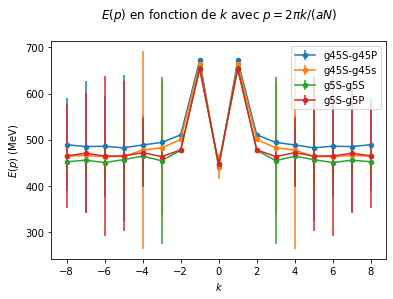

In [130]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45P)*x, np.array(sigmajn_g45S_g45P)*x,marker=".", mew=2.5, label="g45S-g45P")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g45S)*x, np.array(sigmajn_g45S_g45S)*x,marker=".", mew=2.5, label="g45S-g45s")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5S)*x, np.array(sigmajn_g5S_g5S)*x,marker=".", mew=2.5, label="g5S-g5S")
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g5P)*x, np.array(sigmajn_g5S_g5P)*x,marker=".", mew=2.5, label="g5S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g5-S

In [131]:
a =  0.0652
x = (1/a)*197.327
nconf = 999

In [132]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g5S = []
E0unb_g45S_g5S = []
sigmajn_g45S_g5S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g5S.append(E0)
    E0unb_g45S_g5S.append(E0unb)
    sigmajn_g45S_g5S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15727590759781554 +/- 0.016978040634907397
M biased = 475.9936045790514 +/- 51.38383166203025 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15490405320302394 +/- 0.00737152673860084
M biased = 468.81521635572255 +/- 22.309835226194604 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1572158542302827 +/- 0.010811089660468065
M biased = 475.8118537990644 +/- 32.71963020599973 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1563230997

In [133]:
donnees_g45S_g5S = np.array(list(zip(E0_g45S_g5S, E0unb_g45S_g5S, sigmajn_g45S_g5S)))
np.savetxt('__g45S_g5S.dat', donnees_g45S_g5S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

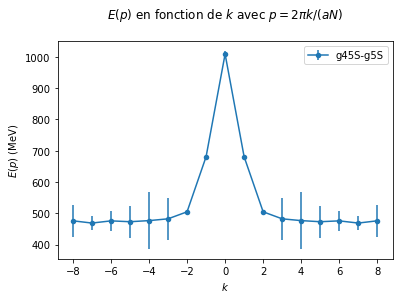

In [134]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g5S)*x, np.array(sigmajn_g45S_g5S)*x,marker=".", mew=2.5, label="g45S-g5S")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g45-S pion-g5-P

In [135]:
list_fichiers = ["./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g45S_g5P = []
E0unb_g45S_g5P = []
sigmajn_g45S_g5P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g45S_g5P.append(E0)
    E0unb_g45S_g5P.append(E0unb)
    sigmajn_g45S_g5P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16484763950693523 +/- 0.05432133380261219
M biased = 498.9093582973162 +/- 164.40285023417266 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16277037403098302 +/- 0.05819316609110457
M biased = 492.62253982226673 +/- 176.1209031481502 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1639262326888807 +/- 0.0361058116961287
M biased = 496.1207318680793 +/- 109.27379608223909 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


900
E0 biased= 0.1616340497830884 +/- 0.07001815808395202
M biased = 489.18346842864247 +/- 211.90909632257674 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16512135811267922 +/- 0.06916852921802073
M biased = 499.73776429908986 +/- 209.33770498472975 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-3.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.16648667755512747 +/- 0.027482678331872602
M biased = 503.8698868392737 +/- 83.17598876063536 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,0,0.pion-g5-P,0.px0_py0_pz-2.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1690041162728828 +/- 0.0010322350936308412
M biased = 511.4888842297416 +/- 3.12404684541247 MeV
Estimation de l'énergie effective de ./data/pion-g45-S,0,1,0,0,1,1,0,

In [136]:
donnees_g45S_g5P = np.array(list(zip(E0_g45S_g5P, E0unb_g45S_g5P, sigmajn_g45S_g5P)))
np.savetxt('__g45S_g5P.dat', donnees_g45S_g5P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

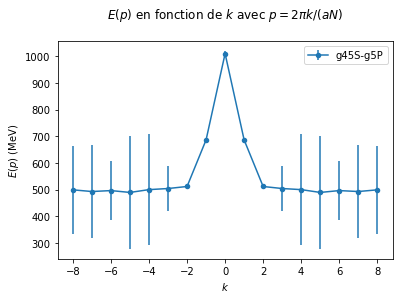

In [137]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g45S_g5P)*x, np.array(sigmajn_g45S_g5P)*x,marker=".", mew=2.5, label="g45S-g5P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g5-S pion-g45-S

In [138]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g45S = []
E0unb_g5S_g45S = []
sigmajn_g5S_g45S = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g45S.append(E0)
    E0unb_g5S_g45S.append(E0unb)
    sigmajn_g5S_g45S.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15174059508799193 +/- 0.00749084549447106
M biased = 459.2410491860152 +/- 22.670951976802012 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100


C:\Users\yacob\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


200
300
400
500
600
700
800
900
E0 biased= 0.1514129284402821 +/- 0.005172899665083178
M biased = 458.249370097171 +/- 15.655717365212706 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15038033992061767 +/- 0.007127924459433021
M biased = 455.1242536122044 +/- 21.572575917278222 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15161408658711736 +/- 0.012925721915495868
M biased = 458.8581727603698 +/- 39.119538779433334 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-S,0.px0_py0_pz-4.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.153344448420903 +/- 0.013167986709190862
M biased = 464.09509161888855 +/- 39.85275020497708 MeV
Estimation de l'énergie effective de ./da

In [139]:
donnees_g5S_g45S = np.array(list(zip(E0_g5S_g45S, E0unb_g5S_g45S, sigmajn_g5S_g45S)))
np.savetxt('__g5S_g45S.dat', donnees_g5S_g45S, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

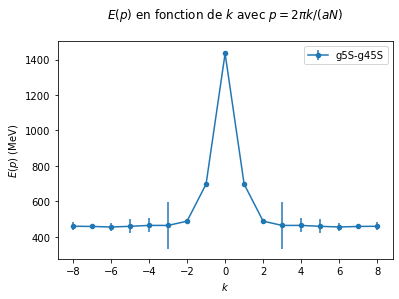

In [140]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g45S)*x, np.array(sigmajn_g5S_g45S)*x,marker=".", mew=2.5, label="g5S-g45S")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

## pion-g5-S pion-g45-P

In [141]:
list_fichiers = ["./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz"+ str(i) + ".m-0.3303_m-0.3303.n3.dat" for i in range(-8, 9)]
E0_g5S_g45P = []
E0unb_g5S_g45P = []
sigmajn_g5S_g45P = []
for fichier in list_fichiers:
    print("Estimation de l'énergie effective de " + fichier)
    E0jn, E0, E0unb, sigmajn = jacknife(nconf,fichier, a, x)
    E0_g5S_g45P.append(E0)
    E0unb_g5S_g45P.append(E0unb)
    sigmajn_g5S_g45P.append(sigmajn)

Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-8.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15261468285831642 +/- 0.034577876935691906
M biased = 461.8864650978989 +/- 104.64952027744292 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-7.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15407562055179064 +/- 0.04929966808349786
M biased = 466.30797510158277 +/- 149.20484055080343 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-6.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.15355220078667628 +/- 0.04150482202776347
M biased = 464.72385160479257 +/- 125.61383460540618 MeV
Estimation de l'énergie effective de ./data/pion-g5-S,0,1,0,0,1,1,0,0,0.pion-g45-P,0.px0_py0_pz-5.m-0.3303_m-0.3303.n3.dat
0
100
200
300
400
500
600
700
800
900
E0 biased= 0.1530517

In [142]:
donnees_g5S_g45P = np.array(list(zip(E0_g5S_g45P, E0unb_g5S_g45P, sigmajn_g5S_g45P)))
np.savetxt('__g5S_g45P.dat', donnees_g5S_g45P, fmt='%.20f', delimiter='\t')

Text(0.5, 0, '$k$')

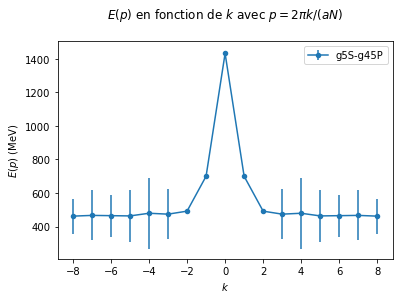

In [143]:
plt.errorbar([i for i in range(-8,9)], np.array(E0_g5S_g45P)*x, np.array(sigmajn_g5S_g45P)*x,marker=".", mew=2.5, label="g5S-g45P")
#plt.plot([i for i in range(-8,9)], pi,marker=".", mew=2.5, label = "p")
plt.legend()
plt.title(r"$E(p)$ en fonction de $k$ avec $p=2 \pi k/ (aN)$"+ "\n")
plt.ylabel(r"$E(p)$ (MeV)")
plt.xlabel(r"$k$")

In [144]:
donnees_g5S_g5S = np.array(list(zip(E0_g5S_g5S, E0unb_g5S_g5S, sigmajn_g5S_g5S)))
np.savetxt('_g5S_g5S.dat', donnees_g5S_g5S, fmt='%.20f', delimiter='\t')
donnees_g5S_g5P = np.array(list(zip(E0_g5S_g5P, E0unb_g5S_g5P, sigmajn_g5S_g5P)))
np.savetxt('_g5S_g5P.dat', donnees_g5S_g5P, fmt='%.20f', delimiter='\t')
donnees_g5S_g45S = np.array(list(zip(E0_g5S_g45S, E0unb_g5S_g45S, sigmajn_g5S_g45S)))
np.savetxt('_g5S_g45S.dat', donnees_g5S_g45S, fmt='%.20f', delimiter='\t')
donnees_g5S_g45P = np.array(list(zip(E0_g5S_g45P, E0unb_g5S_g45P, sigmajn_g5S_g45P)))
np.savetxt('_g5S_g45P.dat', donnees_g5S_g45P, fmt='%.20f', delimiter='\t')
donnees_g45S_g5S = np.array(list(zip(E0_g45S_g5S, E0unb_g45S_g5S, sigmajn_g45S_g5S)))
np.savetxt('_g45S_g5S.dat', donnees_g45S_g5S, fmt='%.20f', delimiter='\t')
donnees_g45S_g5P = np.array(list(zip(E0_g45S_g5P, E0unb_g45S_g5P, sigmajn_g45S_g5P)))
np.savetxt('_g45S_g5P.dat', donnees_g45S_g5P, fmt='%.20f', delimiter='\t')
donnees_g45S_g45S = np.array(list(zip(E0_g45S_g45S, E0unb_g45S_g45S, sigmajn_g45S_g45S)))
np.savetxt('_g45S_g45S.dat', donnees_g45S_g45S, fmt='%.20f', delimiter='\t')
donnees_g45S_g45P = np.array(list(zip(E0_g45S_g45P, E0unb_g45S_g45P, sigmajn_g45S_g45P)))
np.savetxt('_g45S_g45P.dat', donnees_g45S_g45P, fmt='%.20f', delimiter='\t')